#Податочно множество
Симнете го датасетот од линкот кој ви е поставен на самата задача, потоа истиот поставете го локално за да го вчитате.
Во случај на грешка при вчитување на .csv додадете аргумент `encoding='latin-1`


In [37]:
!pip install transformers[torch] datasets evaluate

In [38]:
!gdown 1bqgqgMM1G_rfxyFO97Xx47AZKQN485su

Downloading...
From: https://drive.google.com/uc?id=1bqgqgMM1G_rfxyFO97Xx47AZKQN485su
To: /content/df_file.csv
100% 5.10M/5.10M [00:00<00:00, 166MB/s]


In [39]:
import pandas as pd
from datasets import load_dataset

In [40]:
data = pd.read_csv("/content/df_file.csv")
data

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0
...,...,...
2220,India opens skies to competition\n \n India wi...,4
2221,Yukos bankruptcy 'not US matter'\n \n Russian ...,4
2222,Survey confirms property slowdown\n \n Governm...,4
2223,High fuel prices hit BA's profits\n \n British...,4


In [41]:
data['Label'].value_counts()

1    511
4    510
0    417
2    401
3    386
Name: Label, dtype: int64

In [42]:
dataset = load_dataset("csv", data_files="/content/df_file.csv")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Text', 'Label'],
        num_rows: 2225
    })
})

In [43]:
from sklearn.preprocessing import LabelEncoder

In [44]:
encoder = LabelEncoder()

In [45]:
dataset['train'] = dataset['train'].add_column('label', encoder.fit_transform(dataset['train']['Label']))

In [46]:
dataset['train'] = dataset['train'].remove_columns('Label')

In [47]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Text', 'label'],
        num_rows: 2225
    })
})

In [48]:
dataset = dataset['train'].train_test_split(test_size=0.2)

In [49]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True)

In [51]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

In [52]:
import numpy as np
import evaluate

metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [53]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    learning_rate=5e-5
)

In [54]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1780
    })
    test: Dataset({
        features: ['Text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 445
    })
})

In [55]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

In [56]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [23]:
trainer.train()

KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

In [ ]:
predictions = trainer.predict(tokenized_datasets['test'])

In [ ]:
predictions

In [ ]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [ ]:
preds

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(classification_report(labels, preds))

In [ ]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='5.2f')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix')

In [ ]:
Text(0.5, 1.0, 'Confusion matrix')

#NEVRONSKA MREZHA MODEL

In [151]:
data = pd.read_csv('/content/df_file.csv')
data

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0
...,...,...
2220,India opens skies to competition\n \n India wi...,4
2221,Yukos bankruptcy 'not US matter'\n \n Russian ...,4
2222,Survey confirms property slowdown\n \n Governm...,4
2223,High fuel prices hit BA's profits\n \n British...,4


In [152]:
data.isna().sum()

Text     0
Label    0
dtype: int64

In [153]:
data.groupby('Label').count()

,Text
Label,
0,417
1,511
2,401
3,386
4,510


In [154]:
data['text_length'] = data['Text'].apply(len)

<Axes: ylabel='Frequency'>

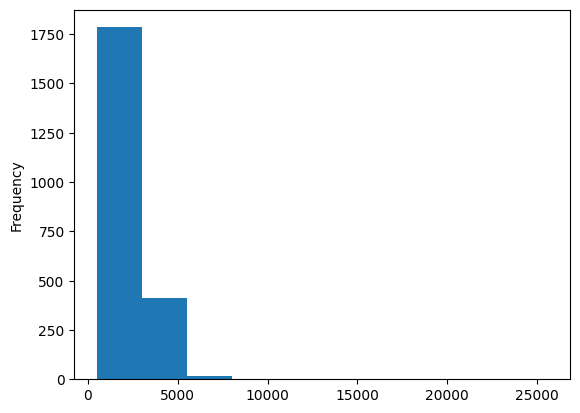

In [155]:
data['text_length'].plot.hist()

In [156]:
X = data['Text']
Y = pd.get_dummies(data['Label'])

In [157]:
num_classes = data['Label'].nunique()

In [158]:
num_classes

5

In [159]:
Y.values

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [160]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [161]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [162]:
data['num_words'] = data['Text'].apply(lambda x: len(x.split(" ")))

<Axes: ylabel='Frequency'>

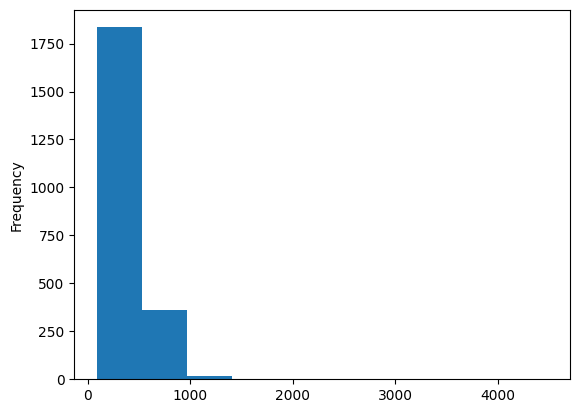

In [163]:
data['num_words'].plot.hist()

In [164]:
max_tokens = 1000

In [165]:
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [166]:
len_tokens = [len(token_list) for token_list in X_train]

(array([1.389e+03, 3.640e+02, 1.800e+01, 3.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([  49. ,  356.5,  664. ,  971.5, 1279. , 1586.5, 1894. , 2201.5,
        2509. , 2816.5, 3124. ]),
 <BarContainer object of 10 artists>)

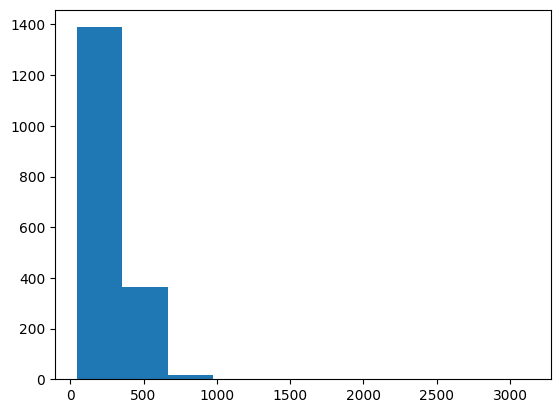

In [167]:
plt.hist(len_tokens)

In [168]:
maxlen=500

In [169]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [170]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1780, 500), (445, 500), (1780, 5), (445, 5))

In [171]:
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report

In [172]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

In [173]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [174]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
112/112 [==============================] - 1s 3ms/step - loss: 21.4996 - precision_4: 0.1944 - recall_4: 0.1899
Epoch 2/10
112/112 [==============================] - 0s 3ms/step - loss: 4.4608 - precision_4: 0.2497 - recall_4: 0.2051
Epoch 3/10
112/112 [==============================] - 0s 2ms/step - loss: 2.2286 - precision_4: 0.3491 - recall_4: 0.2034
Epoch 4/10
112/112 [==============================] - 0s 2ms/step - loss: 1.6645 - precision_4: 0.4611 - recall_4: 0.2034
Epoch 5/10
112/112 [==============================] - 0s 2ms/step - loss: 1.3897 - precision_4: 0.5667 - recall_4: 0.2219
Epoch 6/10
112/112 [==============================] - 0s 1ms/step - loss: 1.2619 - precision_4: 0.6494 - recall_4: 0.2528
Epoch 7/10
112/112 [==============================] - 0s 2ms/step - loss: 1.1699 - precision_4: 0.6667 - recall_4: 0.2753
Epoch 8/10
112/112 [==============================] - 0s 2ms/step - loss: 1.0762 - precision_4: 0.7452 - recall_4: 0.3056
Epoch 9/10
112/112 [===

In [175]:
 history.history

{'loss': [21.499597549438477,
  4.460818767547607,
  2.2285654544830322,
  1.6644656658172607,
  1.3897066116333008,
  1.2619303464889526,
  1.169877529144287,
  1.0762112140655518,
  1.0973589420318604,
  1.0222795009613037],
 'precision_4': [0.19436457753181458,
  0.24965800344944,
  0.34908390045166016,
  0.4611465036869049,
  0.5667144656181335,
  0.649350643157959,
  0.6666666865348816,
  0.7452054619789124,
  0.6941935420036316,
  0.7638072967529297],
 'recall_4': [0.1898876428604126,
  0.20505617558956146,
  0.20337077975273132,
  0.20337077975273132,
  0.22191011905670166,
  0.25280898809432983,
  0.2752808928489685,
  0.3056179881095886,
  0.30224719643592834,
  0.3651685416698456]}

In [183]:
import matplotlib.pyplot as plt


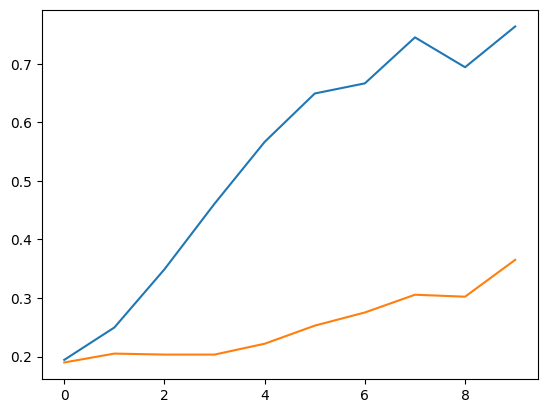

In [177]:
plt.plot(history.history['precision_4'])
plt.plot(history.history['recall_4'])
plt.show()

In [178]:
preds = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


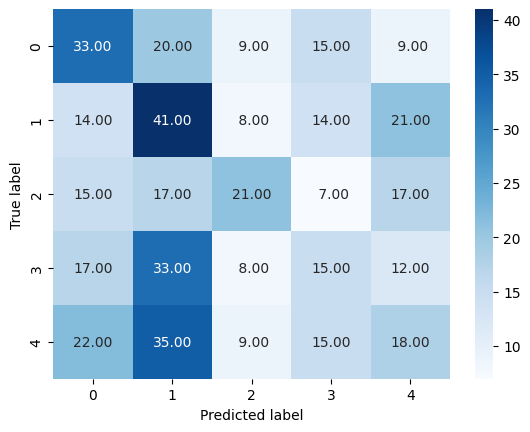

In [179]:
confmat = confusion_matrix(np.argmax(Y_test.values, axis=1), np.argmax(preds, axis=1))
sns.heatmap(confmat, annot=True, cmap='Blues', fmt='5.2f')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [180]:
print(classification_report(np.argmax(Y_test.values, axis=1), np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.33      0.38      0.35        86
           1       0.28      0.42      0.34        98
           2       0.38      0.27      0.32        77
           3       0.23      0.18      0.20        85
           4       0.23      0.18      0.20        99

    accuracy                           0.29       445
   macro avg       0.29      0.29      0.28       445
weighted avg       0.29      0.29      0.28       445

